In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important;font-size: 16px; }</style>"))

%matplotlib inline

import io
import requests
import os
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')    

/Users/naamabendor/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/naamabendor/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/naamabendor/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.wa

## <span style="background-color : azure; color : darkblue;">TL;DR</span>  
**This binary classification analysis is trying to predict which individuals will have an income of over 50K a year.**

**Data wrangling included removal of correlated education variable along with balancing the train set response data.**

**The best performing model is XGBoost with validation AUC of 90.8% and test set AUC of 82.1%**

###  <span style="background-color : azure; color : darkblue;">Table of Contents</span>

* [1. Problem Statement & Data](#chapter1)
* [2. Exploratory Data Analysis](#chapter2)
    * [2.1. Load data and initial review](#section_2_1)
    * [2.2.  Is the response balanced?](#section_2_2)
    * [2.3. Interesting visualizations](#section_2_3)
* [3. Data](#chapter3)
    * [3.1. Data Preparation](#section_3_1)
    * [3.2. Outliers?](#section_3_2)
    * [3.3. Train-Test Split using SMOTE to balance the train data set](#section_3_3)
* [4. Proposed Methoodology](#chapter4)
    * [4.1. Logistic Regression](#section_4_1)
    * [4.2. Random Forest](#section_4_2)
    * [4.3. Gradient Boosting](#section_4_3)
* [5. Validation Results - Choosing a model](#chapter5)    
* [6. Test Set](#chapter6) 
    * [6.1. Minimal processing](#section_6_1)
    * [6.2. Predictions on test set](#section_6_2)
* [7. Conclusions & Next Steps](#chapter7) 

## <a class="anchor" id="chapter1"></a> <span style="background-color : azure; color : darkblue;">1. Problem Statement & Data</span>  

Employees wage levels have a significant effect on all aspects of life, family and well being. Understanding the wage class an employee is likely to earn based on demographic and socio-economic factors can be used in a variety of ways to assist decision makers (goverenment, commercial, employers ect) in planning their strategy.

The data set for this analysis is based on 1994 US Census and consists of 48842 observations. Each observation includes wage class ('>50K', '<=50K') along with the following 14 predictors:
1. age - emploee's age in years (integer) 
2. workclass - employee's sector of employement (categorical, 8 levels)
3. fnlwgt - weight of observation out of total observations (integer)
4. education - employee's level of education (categorical)
5. education-num - employee's number of education years (integer)
6. marital-status - employee's marital status (categorical)
7. occupation - employee's occupation (categorical)
8. relationship - employee's relationship as it relates to immidiate family (categorical) 
9. race - employee's race (categorical)
10. sex - employee's sex (categorical)
11. capital-gain - employee's capital gain (integer)
12. capital-loss - employee's capital loss (integer)
13. hours-per-week - average hours of work per week (integer)
14. native-country - employee's country of origin (categorical)

The original data set is spit into train_data (2/3 of observations) and test_data (1/3 of observations).



##  <a class="anchor" id="chapter2"></a> <span style="background-color : azure; color : darkblue;">2. Exploratoty Data Analysis</span>  

In [2]:
#load data
def get_data(path, urls):
    if not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        data = requests.get(url).content
        filename = os.path.join(path, os.path.basename(url))
        with open(filename, "wb") as file:
            file.write(data)

In [3]:
urls = ["https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"]
get_data('data', urls)

In [4]:
columns = ["age", "workclass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "class"]
train_data = pd.read_csv('data/adult.data', names=columns,sep=',')
test_data  = pd.read_csv('data/adult.test', names=columns, sep=',', skiprows=1)

### <a class="anchor" id="section_2_1"></a> <span style="background-color : azure; color : darkblue;">2.1. Load data and initial review </span>  



In [5]:
#initial review of the data
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
#check data types and null values, we can see there are no NaN values
#but we can observe in the categorical variables below '?', will be addressed later in the analysis
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [7]:
#check that test_data is in the same format as train_data (since they were loaded from 2 seperate files)
test_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workclass       16281 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education-num   16281 non-null  int64 
 5   marital-status  16281 non-null  object
 6   occupation      16281 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital-gain    16281 non-null  int64 
 11  capital-loss    16281 non-null  int64 
 12  hours-per-week  16281 non-null  int64 
 13  native-country  16281 non-null  object
 14  class           16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


In [9]:
#Review of categorical variables, '?' will be treated as 'other' under the preference of not imputing categorical variabls

for category in train_data.select_dtypes(include=['object']):
    print('\n'+category+':\n\n',sorted(train_data[category].unique()))


workclass:

 [' ?', ' Federal-gov', ' Local-gov', ' Never-worked', ' Private', ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay']

education:

 [' 10th', ' 11th', ' 12th', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' Assoc-acdm', ' Assoc-voc', ' Bachelors', ' Doctorate', ' HS-grad', ' Masters', ' Preschool', ' Prof-school', ' Some-college']

marital-status:

 [' Divorced', ' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent', ' Never-married', ' Separated', ' Widowed']

occupation:

 [' ?', ' Adm-clerical', ' Armed-Forces', ' Craft-repair', ' Exec-managerial', ' Farming-fishing', ' Handlers-cleaners', ' Machine-op-inspct', ' Other-service', ' Priv-house-serv', ' Prof-specialty', ' Protective-serv', ' Sales', ' Tech-support', ' Transport-moving']

relationship:

 [' Husband', ' Not-in-family', ' Other-relative', ' Own-child', ' Unmarried', ' Wife']

race:

 [' Amer-Indian-Eskimo', ' Asian-Pac-Islander', ' Black', ' Other', ' White']

sex:

 [' Female'

In [10]:
#check that all categories are equal between train and test data for each categorical variable
#there is a difference in the 'class' variable, will be addressed later
#there are also differences in the 'native-country' variable
for category in test_data.select_dtypes(include=['object']):
    print(sorted(train_data[category].unique()) == sorted(test_data[category].unique()))

True
True
True
True
True
True
True
False
False


In [11]:
#a closer look at the 'native-country' variable:
#the difference is coming from a category in the train set that doesn't appear in the test set

print(len(train_data['native-country'].unique()))
print(len(test_data['native-country'].unique()))

set(train_data['native-country']).difference(test_data['native-country'])

42
41


{' Holand-Netherlands'}

In [12]:
#check how many observations of 'native-country' exist for each country
#' Holand-Netherlands' has only 1 observation, since it doesn't exist in the
# test data it will be removed to avoid shape differences (difference in number 
#of columns after converting into dummy variables)
train_data['native-country'].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [13]:
train_data = train_data[train_data['native-country'] != ' Holand-Netherlands']

In [14]:
#initial basic statistics for the numeric variables
train_data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581849,1.897833e+05,10.080682,1077.681941,87.238790,40.437469
std,13.640593,1.055478e+05,2.572760,7385.403083,402.795459,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


### <a class="anchor" id="section_2_2"></a> <span style="background-color : azure; color : darkblue;">2.2. Is the response balanced? </span>  

#### 24.08% of the train_data class response variable are over 50K, while 75.92% are under 50K. This will be addressed later in the analysis.

In [15]:
#review the ratio of observations per class out of total observation
print(train_data.groupby('class').size())

#convert 'class' to binary categorical variable, '<=50K'==0, '>50K'==1
train_data['class'] = pd.Categorical(train_data['class'])
train_data['class'] = train_data['class'].cat.codes

#check the response distribution
count_under50K = len(train_data[train_data['class']==0])
count_over50K = len(train_data[train_data['class']==1])
pct_under50K = count_under50K/(count_under50K+count_over50K)
print("percentage of under 50K", pct_under50K*100)
pct_over50K = count_over50K/(count_under50K+count_over50K)
print("percentage of over 50K", pct_over50K*100)

class
 <=50K    24719
 >50K      7841
dtype: int64
percentage of under 50K 75.91830466830467
percentage of over 50K 24.081695331695332


### <a class="anchor" id="section_2_3"></a> <span style="background-color : azure; color : darkblue;">2.3. Interesting visualizations </span>

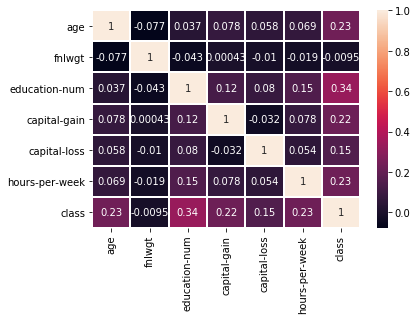

In [16]:
corr=train_data.corr()
sns.heatmap(corr,annot=True,lw=1)

#### The correlation matrix doesn't demonstrates very high correlations between the numeric variables, highest being 0.15 (excluding 'class'). 

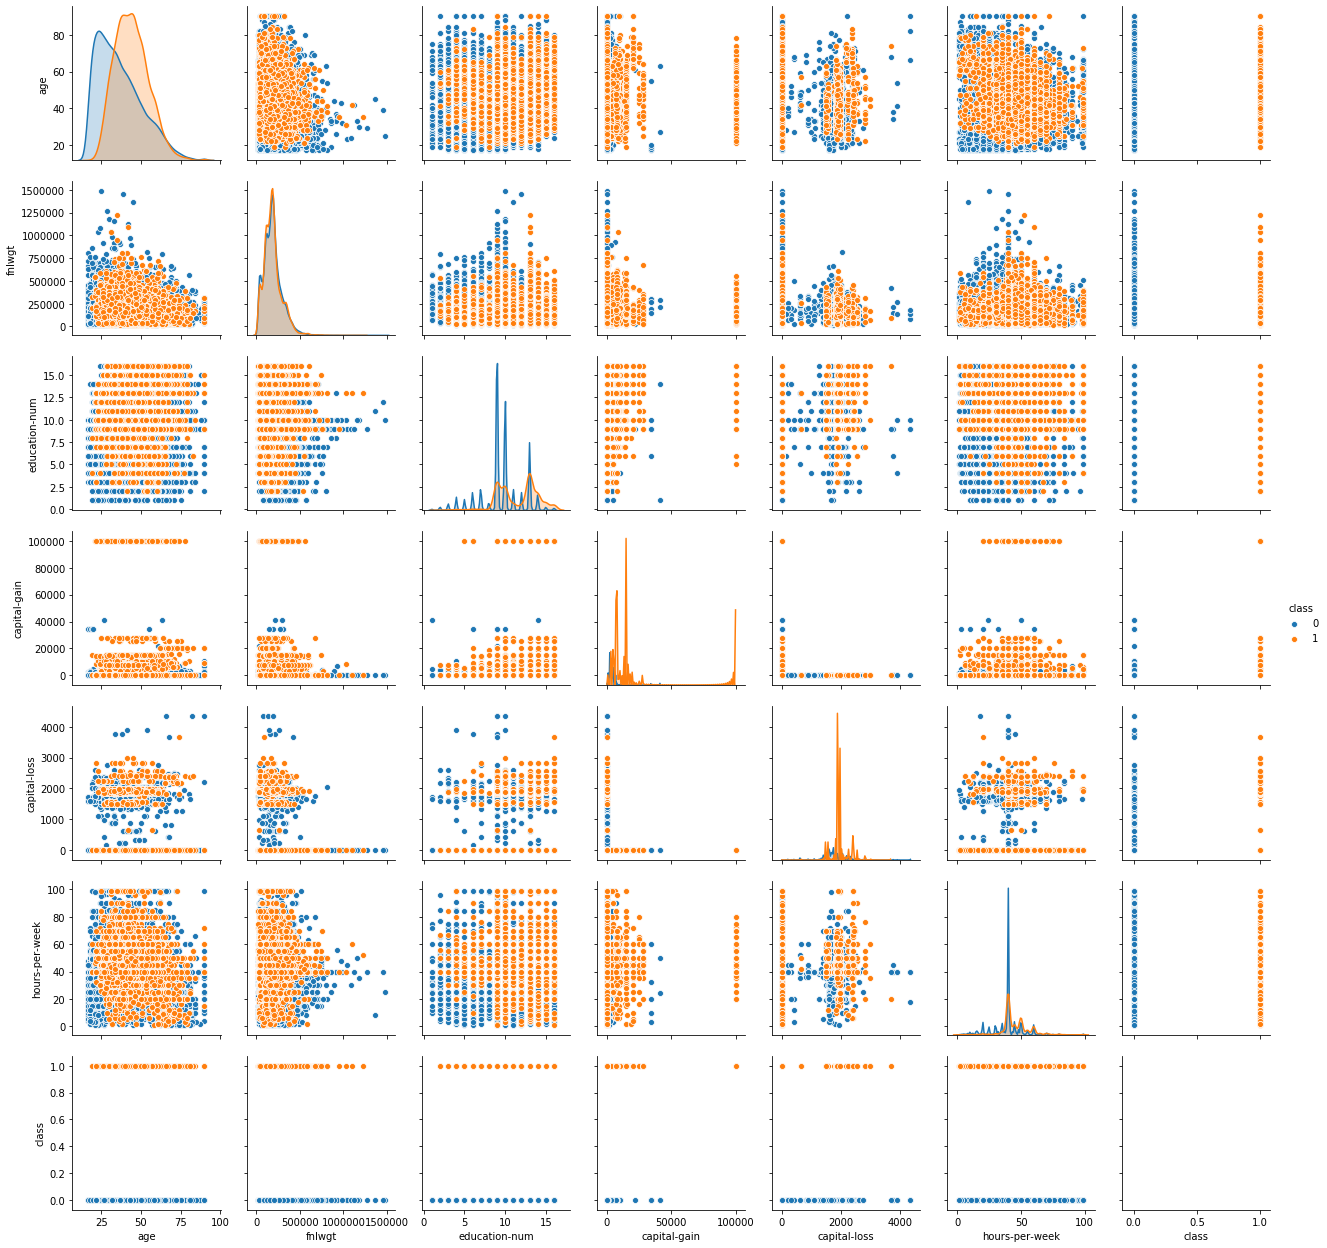

In [17]:
sns.pairplot(train_data, hue='class')

#### The pair plots represent the relationships between the numeric variables by wage class. From the plot we can see that age, education-num and hours per week have significantly different distribution by wage class (diagonal density plots), and are likely to be important for classification . We can also observe clear differences when reviewing the relationships between variables by class.

#### Education level is provided in the initial data both as a categorical variable and as ש numeric variable. Below we can see that the information in both categories is consistent, therefore I will only keep education-num moving forward to avoid multicollinearity

Text(0.5, 1.0, 'Copmarison of education and education-num variables')

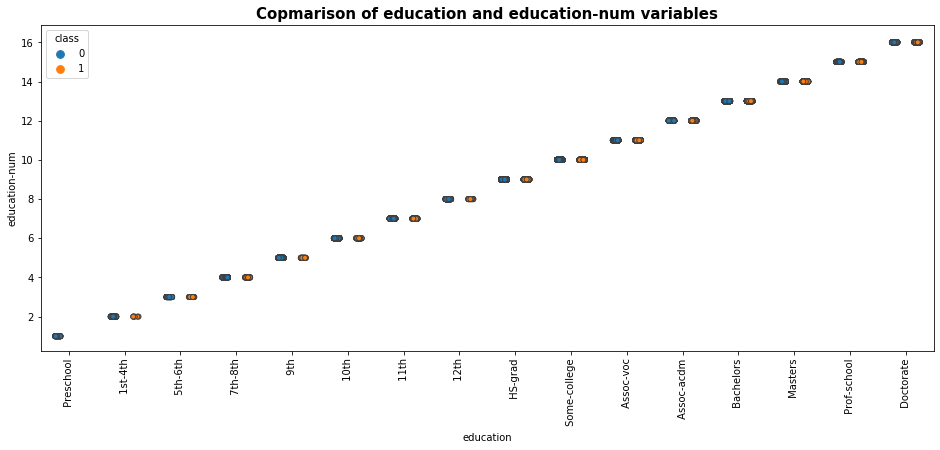

In [18]:
plt.figure(figsize=(16, 6))
plt.xticks(rotation=90)
sns.stripplot(data=train_data.sort_values(by=['education-num']), x='education', y="education-num", hue="class",
               split=True, linewidth=1).set_title('Copmarison of education and education-num variables', fontweight='bold', fontsize=15 )

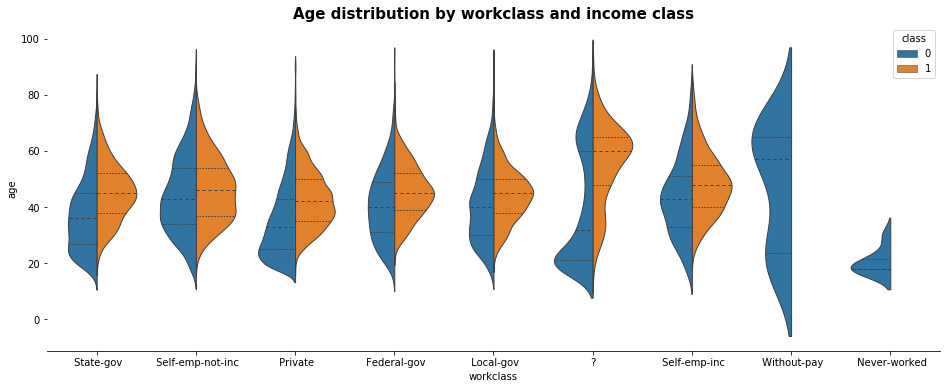

In [19]:
#split violinplot for easier comparison of age distribution by workclass and by income class
plt.figure(figsize=(16, 6))
sns.violinplot(data=train_data, x="workclass", y="age", hue="class",
               split=True, inner="quart", linewidth=1).set_title('Age distribution by workclass and income class', 
                                                                 fontweight='bold', fontsize=15)
              
sns.despine(left=True)

##  <a class="anchor" id="chapter3"></a> <span style="background-color : azure; color : darkblue;">3. Data </span>  

### <a class="anchor" id="section_3_1"></a> <span style="background-color : azure; color : darkblue;">3.1. Data Preparation  </span>

#### Review of '?' - these appear consistently in the trtain and test set. Imputing a categorical variable using the mode value is not a relaible technique, therefore these rows will be kept and treated and another level of the categorigal variables ('Other')

In [20]:
#check how many '?' are there in the train data:
train_data.isin([' ?']).sum(axis=0)

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
class                0
dtype: int64

In [21]:
#check how many '?' are there in the test data:
test_data.isin([' ?']).sum(axis=0)

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
class               0
dtype: int64

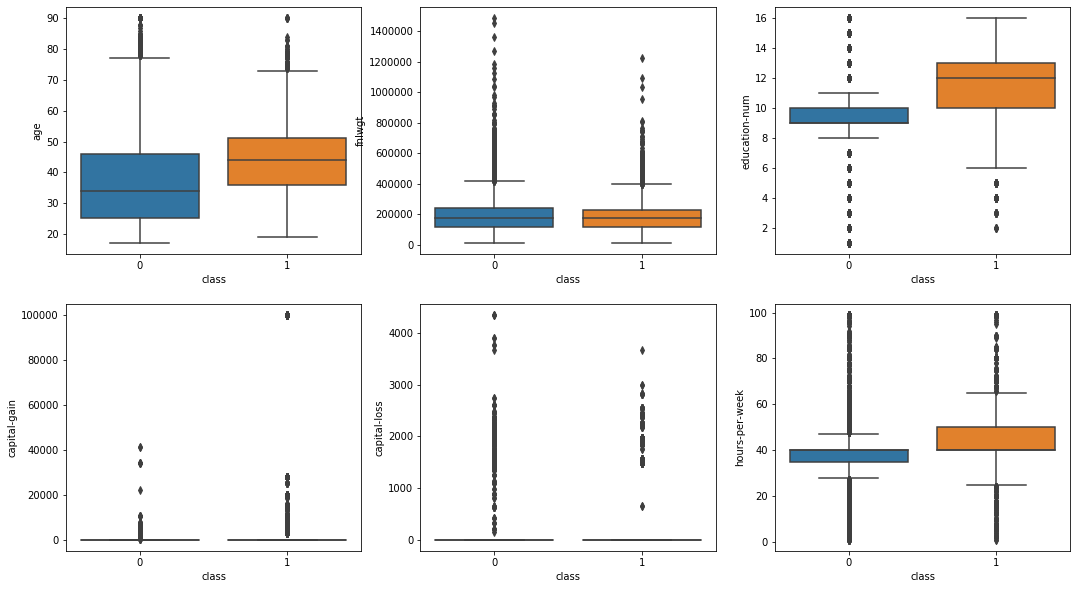

In [22]:
col_names = train_data.columns.to_list()
num_vars = [col for col in train_data.select_dtypes(include=['int64'])]

plt.figure(figsize=(18,10))

for i, col in enumerate(num_vars,1):
        plt.subplot(2,3,i) 
        sns.boxplot(y=col, x='class',data=train_data)

In [23]:
#education and education-num - from the above EDA both reflect the same information consistently - remove 
#education to avoid multicollinearity
#fnlwgt - intuitivly this variable is expected to have little to none explanatory power for classification, 
#the above correlation plot (correlation of -0.0095 to 'class') and box plot (medians are almost identical) support this
#therefore will be removed
train_data = train_data[col_names[:2]+col_names[4:15]]

In [24]:
train_data

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


### <a class="anchor" id="section_3_2"></a> <span style="background-color : azure; color : darkblue;">3.2. Outliers?</span>  
 
#### From the above boxplots we can see that there are outliers in our data, will be removed to improve model performance

In [25]:
z = np.abs(stats.zscore(train_data.select_dtypes(include='number')))
print(np.where(z > 3))

(array([   10,    23,    28, ..., 32524, 32524, 32530]), array([4, 3, 4, ..., 0, 4, 4]))


In [26]:
train_data = train_data[(z<3).all(axis=1)]

In [27]:
train_data

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [28]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30151 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30151 non-null  int64 
 1   workclass       30151 non-null  object
 2   education-num   30151 non-null  int64 
 3   marital-status  30151 non-null  object
 4   occupation      30151 non-null  object
 5   relationship    30151 non-null  object
 6   race            30151 non-null  object
 7   sex             30151 non-null  object
 8   capital-gain    30151 non-null  int64 
 9   capital-loss    30151 non-null  int64 
 10  hours-per-week  30151 non-null  int64 
 11  native-country  30151 non-null  object
 12  class           30151 non-null  int8  
dtypes: int64(5), int8(1), object(7)
memory usage: 3.0+ MB


In [29]:
train_data.groupby('class').count()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
class,,,,,,,,,,,,
0,23425,23425,23425,23425,23425,23425,23425,23425,23425,23425,23425,23425
1,6726,6726,6726,6726,6726,6726,6726,6726,6726,6726,6726,6726


In [30]:
train_data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week,class
count,30151.000000,30151.000000,30151.000000,30151.000000,30151.000000,30151.000000
mean,38.108686,10.074724,570.176147,1.196411,39.893669,0.223077
std,13.344673,2.454053,2331.645311,32.536100,11.127342,0.416317
min,17.000000,3.000000,0.000000,0.000000,4.000000,0.000000
25%,27.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,79.000000,16.000000,22040.000000,1258.000000,77.000000,1.000000


### <a class="anchor" id="section_3_3"></a> <span style="background-color : azure; color : darkblue;">3.3. Train-Test Split using SMOTE to balance the train data set</span> 

#### Since our response variable is unbalanced, I will use SMOTE (Synthetic Minority Oversampling Technique) over-sampling on the **training data** to create balanced response in the training data set for improved model accuracy, while keeping testing data in original form.
#### The data is split into train (70%) and validation (30%) sets.

In [31]:
X = train_data.iloc[:,:12]
X

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,40,Private,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,58,Private,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,22,Private,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


#### Create dummy variable for all categorical variables:

In [32]:
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,13,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y = train_data['class']
y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: class, Length: 30151, dtype: int8

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os = SMOTE(random_state=0)
os_data_X,os_data_y = os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['class'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of under 50K in oversampled data",len(os_data_y[os_data_y['class']==0]))
print("Number of over 50K",len(os_data_y[os_data_y['class']==1]))
print("Proportion of under 50K in oversampled data is ",len(os_data_y[os_data_y['class']==0])/len(os_data_X))
print("Proportion of over 50K in oversampled data is ",len(os_data_y[os_data_y['class']==1])/len(os_data_X))

length of oversampled data is  32898
Number of under 50K in oversampled data 16449
Number of over 50K 16449
Proportion of under 50K in oversampled data is  0.5
Proportion of over 50K in oversampled data is  0.5


## <a class="anchor" id="chapter4"></a> <span style="background-color : azure; color : darkblue;">4. Proposed Methodology</span>  
#### In order to predict wage classes the analysis is conducted using multiple classification methods:

#### <a class="anchor" id="section_4_1"></a> <span style="background-color : azure; color : darkblue;">4.1. Logistic Regression</span> 
**Supervised learning algorithm that uses a logistic function to model a binary dependent variable by predicting a probability for each observation and comparing it to a predefined threshold.**

#### <a class="anchor" id="section_4_2"></a><span style="background-color : azure; color : darkblue;">4.2. Random Forest</span> 
**Random Forest is an ensemble learning method based on decision trees, that operates by randomly constructing many decision trees at training time, each with a different subset of features and observations, and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees.**

#### <a class="anchor" id="section_4_3"></a><span style="background-color : azure; color : darkblue;">4.3. Gradient Boosting</span> 
**Gradient Boosting model is an ensemble method that combines learners in the form of decision trees into a single more robust learner in an iterative way. Probability prediction using a gradient boosting model is based on the iterative predictions until the model performance improves less than a predefined threshold.**



In [35]:
# Logistic regression coefs
logreg_model = LogisticRegression(random_state=0).fit(os_data_X, os_data_y)
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logreg_model.score(os_data_X, os_data_y)))
print('Accuracy of Logistic Regression classifier on validation set: {:.2f}'
     .format(logreg_model.score(X_test, y_test)))
logreg_model.intercept_

Accuracy of Logistic Regression classifier on training set: 0.84
Accuracy of Logistic Regression classifier on validation set: 0.80


array([-1.77214766])

In [36]:
coeff_parameter = pd.DataFrame(logreg_model.coef_.transpose(), os_data_X.columns, columns=['Coefficient'])
pd.set_option("display.max_rows", None, "display.max_columns", None)
coeff_parameter

,Coefficient
age,0.013241
education-num,0.221772
capital-gain,0.000317
capital-loss,-2.778346
hours-per-week,0.047139
workclass_ Federal-gov,-0.164968
workclass_ Local-gov,-0.680711
workclass_ Never-worked,-0.003016
workclass_ Private,-0.877421
workclass_ Self-emp-inc,-0.192219


Accuracy of Random Forest classifier on training set: 0.98
Accuracy of Random Forest classifier on validation set: 0.83


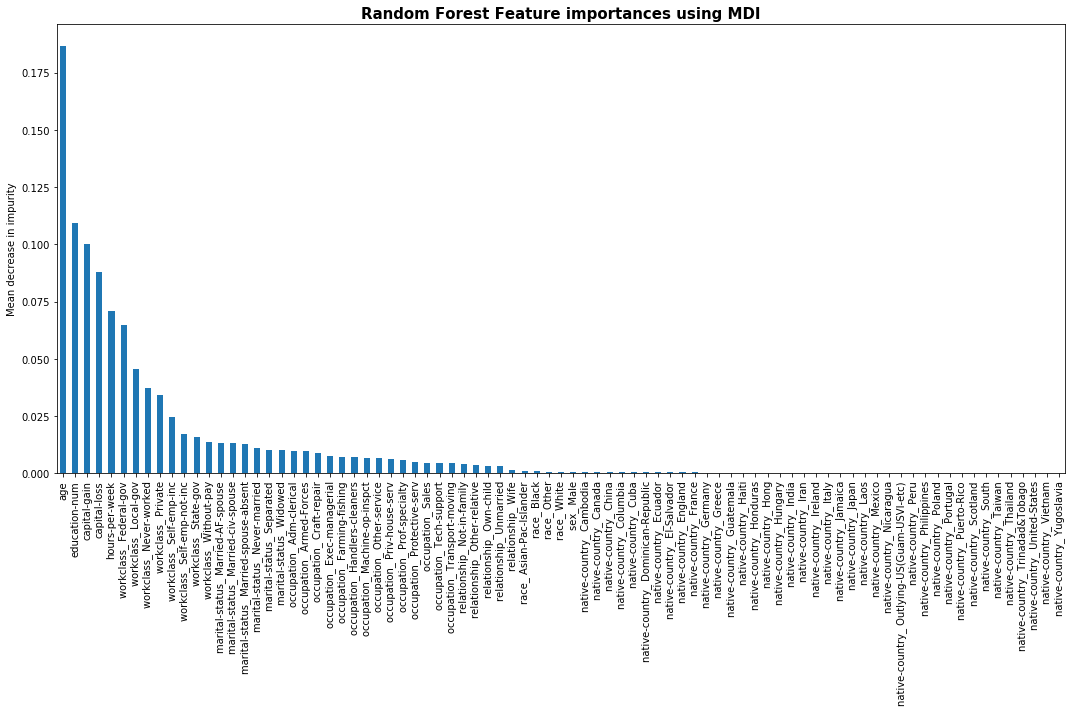

In [37]:
rf_model = RandomForestClassifier(random_state=0).fit(os_data_X, os_data_y)
print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(rf_model.score(os_data_X, os_data_y)))
print('Accuracy of Random Forest classifier on validation set: {:.2f}'
     .format(rf_model.score(X_test, y_test)))
feature_names = os_data_X.columns
importances = sorted(rf_model.feature_importances_, reverse=True)
rf_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots(figsize=(15, 10))
rf_importances.plot.bar(ax=ax)
ax.set_title("Random Forest Feature importances using MDI", fontweight='bold', fontsize=15)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Accuracy of XGB classifier on training set: 0.86
Accuracy of XGB classifier on validation set: 0.82


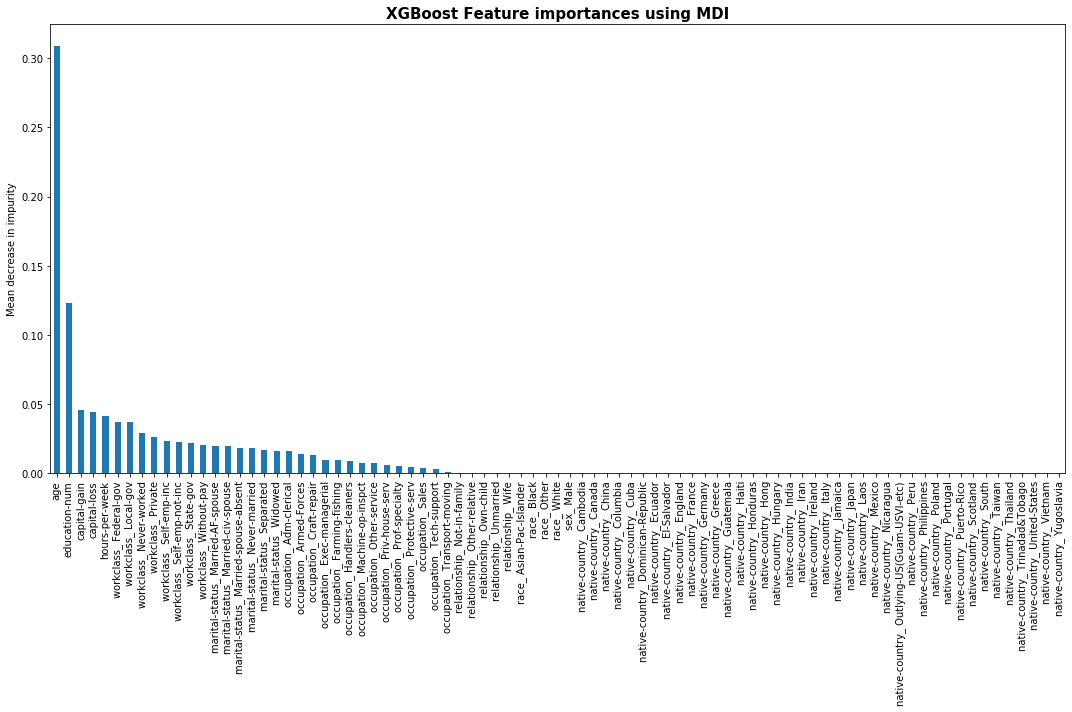

In [38]:
xgb_model = xgb.XGBClassifier(objective= 'binary:logistic', seed=0).fit(os_data_X, os_data_y)
print('Accuracy of XGB classifier on training set: {:.2f}'
     .format(xgb_model.score(os_data_X, os_data_y)))
print('Accuracy of XGB classifier on validation set: {:.2f}'
     .format(xgb_model.score(X_test, y_test)))
importances2 = sorted(xgb_model.feature_importances_, reverse=True)
xgb_importances = pd.Series(importances2, index=feature_names)
fig, ax = plt.subplots(figsize=(15, 10))
xgb_importances.plot.bar(ax=ax)
ax.set_title("XGBoost Feature importances using MDI", fontweight='bold', fontsize=15)
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [39]:
# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=0), 
               RandomForestClassifier(random_state=0),
               xgb.XGBClassifier(objective= 'binary:logistic', seed=0)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(os_data_X, os_data_y)
    yproba = model.predict_proba(X_test)[::,1]
    print(cls.__class__.__name__,'\n\n', classification_report(y_test, model.predict(X_test)))
    fpr, tpr, thresholds = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    #find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_threshold
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc,
                                        'optimal_threshold':optimal_threshold}, ignore_index=True)
    
# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
result_table[['auc','optimal_threshold']]

LogisticRegression 

               precision    recall  f1-score   support

           0       0.92      0.82      0.86      6976
           1       0.55      0.75      0.63      2070

    accuracy                           0.80      9046
   macro avg       0.73      0.78      0.75      9046
weighted avg       0.83      0.80      0.81      9046

RandomForestClassifier 

               precision    recall  f1-score   support

           0       0.89      0.89      0.89      6976
           1       0.63      0.64      0.63      2070

    accuracy                           0.83      9046
   macro avg       0.76      0.76      0.76      9046
weighted avg       0.83      0.83      0.83      9046

XGBClassifier 

               precision    recall  f1-score   support

           0       0.94      0.82      0.87      6976
           1       0.57      0.83      0.68      2070

    accuracy                           0.82      9046
   macro avg       0.76      0.82      0.78      9046
weighted 

,auc,optimal_threshold
classifiers,,
LogisticRegression,0.879449,0.388159
RandomForestClassifier,0.876095,0.280000
XGBClassifier,0.908405,0.403183


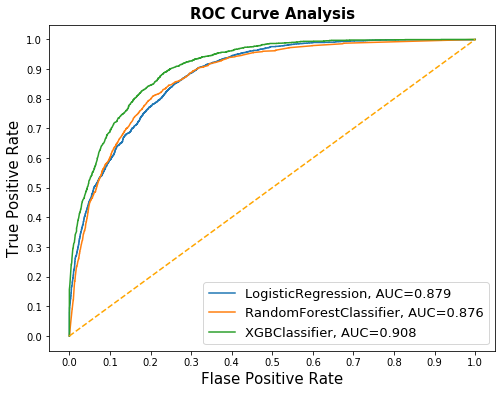

In [40]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

## <a class="anchor" id="chapter5"></a>  <span style="background-color : azure; color : darkblue;">5. Validation Results - Choosing a model</span> 

#### Model performance will be evaluated based on ROC curve Analysis and F1 score:

Logistic regression: 

AUC = 0.879, F1 Score = 0.86/0.63 (0/1)

Random Forest: 

AUC = 0.876, F1 Score = 0.89/0.63 (0/1)

Gradient Boosting: 

AUC = 0.908, F1 Score = 0.87/0.68 (0/1)

Based on the success measures displayed above, it appears that the XGBoost model is the best alternative for the wage class prediction with highest AUC and competitve/high (0/1) F1-score.

## <a class="anchor" id="chapter6"></a>  <span style="background-color : azure; color : darkblue;">6. TEST SET</span> 
### <a class="anchor" id="section_6_1"></a>  <span style="background-color : azure; color : darkblue;">6.1. Minimal processing</span> 

In [41]:
X_TEST_DATA = test_data[col_names[:2]+col_names[4:14]]
X_TEST_DATA = pd.get_dummies(data=X_TEST_DATA, drop_first=True)
pd.set_option("display.max_rows", 20, "display.max_columns", 20)
X_TEST_DATA

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,25,7,0,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,38,9,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,28,12,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,10,7688,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,18,10,0,0,30,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,13,0,0,36,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
16277,64,9,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
16278,38,13,0,0,50,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
16279,44,13,5455,0,40,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [42]:
#convert 'class' to binary categorical variable, '<=50K'==0, '>50K'==1
test_data['class'] = pd.Categorical(test_data['class'])
test_data['class'] = test_data['class'].cat.codes

y_TEST_DATA = test_data['class']
y_TEST_DATA

0        0
1        0
2        1
3        1
4        0
        ..
16276    0
16277    0
16278    0
16279    0
16280    1
Name: class, Length: 16281, dtype: int8

### <a class="anchor" id="section_6_2"></a>  <span style="background-color : azure; color : darkblue;">6.2. Predictions on test set</span> 

In [43]:
#predictions on test set using the default threshold=0.5
TEST_XGB_predictions = XGB_model.predict(X_TEST_DATA)
TEST_XGB_predictions

array([0, 0, 1, ..., 1, 0, 1], dtype=int8)

In [44]:
TEST_XGB_cm = confusion_matrix(y_TEST_DATA,TEST_XGB_predictions)

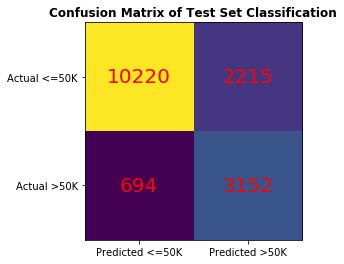

In [45]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(TEST_XGB_cm)
ax.grid(False)
plt.title("Confusion Matrix of Test Set Classification", fontweight='bold', fontsize=12)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted <=50K', 'Predicted >50K'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual <=50K', 'Actual >50K'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, TEST_XGB_cm[i, j], ha='center', va='center', size = 20, color='red')
plt.show()

In [46]:
print(classification_report(y_TEST_DATA, TEST_XGB_predictions))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88     12435
           1       0.59      0.82      0.68      3846

    accuracy                           0.82     16281
   macro avg       0.76      0.82      0.78     16281
weighted avg       0.85      0.82      0.83     16281



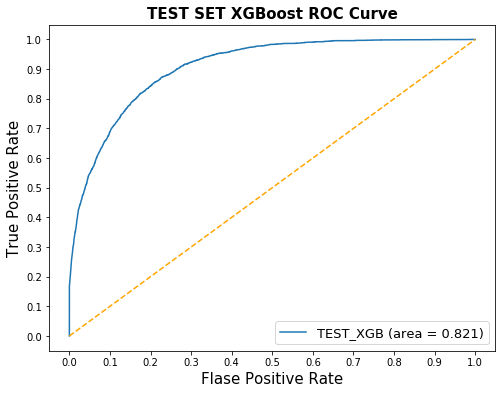

In [47]:
TEST_XGB_roc_auc = roc_auc_score(y_TEST_DATA, TEST_XGB_predictions)
fpr, tpr, thresholds = roc_curve(y_TEST_DATA, XGB_model.predict_proba(X_TEST_DATA)[:,1])
fig = plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='TEST_XGB (area = %0.3f)' % TEST_XGB_roc_auc)

plt.plot([0, 1], [0, 1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('TEST SET XGBoost ROC Curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.savefig('TEST_XGB_ROC')
plt.show()

In [48]:
#find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.44462508

## <a class="anchor" id="chapter7"></a>  <span style="background-color : azure; color : darkblue;">7. Conclusions & Next Steps </span> 

#### <span style="background-color : azure; color : darkblue;">Conclusions: </span>  
## ADD ADD ADD
When reviewing the features identified by the models as most important, it is clear that the most significant predictor of income level is age, along with education-num, capital-gain, capital-loss, hours-per-week wich appear consistently in both random forest and xgboost feature importance. These findidngs are consistent with the density plots by class (in pairs plots) and with correlation matrix findings.

The test set results reflect an AUC of 82.1%, 

confusion matrix threshold

#### <span style="background-color : azure; color : darkblue;">Next steps:</span>

**Handling of ' ?' - additional analysis can examine models behavior with different approaches towards ' ?' such as removeing all ' ?' or imputing based on mode.**

**Categorical features with many levels - additional feature engineering can be done to combine categories with small number of observations. This potentially could increase model prediction success.**

**Outliers - thourogh reveiw of outliers that were removed should be conducted, which could provide valuable information and insights.**

**SMOTE - analysis without SMOTE was conducted and achieved significantly lower performance on test set classification**

**Grid search & parameter tuning - in an effort to increase models performance an in-depth parameter tuning can be conducted**

**fnlwgt - this feature that has been removed for the purpose of this analysis represents the weight of observation out of total observations in the original 1994 US Census data. Would be interesting to analyze a model that combines these weights as part of the analysis.**